# Acquisition Functions
Acquisition Functions (acq. functions) are used to find the *best* next possible point to sample when doing Bayesian Optimization. The term *best* in this context depends on what the user wants to achieve. In our case we want to find the most informative point so that our surrogate model (cf. **Bayesian Optimization**). In this notebook I will introduce three acq. functions. The first one is *Expected Improvement (EI)* which is commonly used and easy to implement. After that I will discuss *Mutual Information (MI)* and *Upper Confidence Bound (UCB)*.
## GP - UCB
Another possible acq. function is the so called *Gaussian Process upper confidence bound (GP-UCB)*. It results from the question: How can we learn an unknown function *f* as fast as possible? *Bayesian Experimental Design (ED)* can help us here since it uses the *informativeness* of a sample point by measuring its *information gain*. The possible sample point belongs to the set $\mathcal{A} \subseteq \mathcal{D}$ where $\mathcal{A}$ is the set of samples in the inputspace $\mathcal{D}$. The *information gain* is expressed trough the *Mutual Information* between the unknown function and the observations $y_A = f_A + \epsilon_A$ with $\epsilon \sim \mathcal{N}(0,I\sigma_n^2)$ at the sampling points in $\mathcal{A}$. *Mutual Information* is defined as
\begin{equation*}
I(y_\mathcal{A}, f) = H(y_\mathcal{A}) - H(y_\mathcal{A}|f)
\end{equation*}
where $H(.)$ is the entropy function. Optimizing this function for $\mathcal{A} \subset \mathcal{D}$ is NP-Hard and therefore approximated by an efficient greedy algorithm which maximizes 
\begin{equation*}
x_t =  \underset{x \in \mathcal{D}}{\mathrm{argmax}} \sigma_{t-1}(x)
\end{equation*}
Sequentaly optimizing this function is proven to be a good way to explore *f* but is not suited for optimization since it does not depend on observations made from the chosen sample points. A better strategy is to optimize 
\begin{equation*}
x_t =  \underset{x \in \mathcal{D}}{\mathrm{argmax}} \big( \mu_{t-1}(x) + \sqrt{\beta_t} \sigma_{t-1} \big)
\end{equation*}
for a finite set $\mathcal{D}$ $\beta_t$ is defined as 
\begin{equation*}
\beta_t = 2 \log(|D|t^2\pi^2 / 6 \delta)
\end{equation*}
where delta is a value of $\delta = (0,1)$. One key fact of this function is that its error can be schon to bounded.<br>
For more information about the acq. function I'd like to refer to the following paper: Gaussian Process Optimization in the Bandit Setting: No Regret and Experimental Design (http://www-stat.wharton.upenn.edu/~skakade/papers/ml/bandit_GP_icml.pdf).

Now the same procedure as before is applied: Start with 2 inital points randomly chosen from a *RBF(l=0.4)* kernel as training set. After that optimize the hyperparameters according to the set, predict the posterior and use the predictions mean and variance to compute the best possible point according to *GP-UCB*. This is done recursively for $N=10$ times and output is plotted. 

Note that optimization is done with regard to only the kernels variance. All the other parameters are fixed and also the the kernel the same kind as the ground truth.

In [2]:
import utils
import acqfunctions as acq
import gpflow
import numpy as np
import matplotlib
#import math
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [3]:
fontsize_label = 24
fontsize_legend = 20
fontsize_ticks = 20
fontsize_title = 24
linewidth = 2.4
markeredgewidth = 3
markersize = 15 
matplotlib.rcParams['figure.figsize'] = (16, 8)

Now create a data set by drawing from a *RBF* kernel. After that *5* random points are chosen as trainig samples for a GP. The posterior together with the ground truth as well as the observed data points are marked to show how a GP posterior conditioned on randomly selected samples looks like.

In [3]:
# Generate data
np.random.seed(9)
# Set some parameters
f = 0.5
N = 6.
lengthscale = 0.4
num_Functions = 1
num = 100
# Build data sets
X = np.linspace(0., N, num).reshape(num, 1)
k = gpflow.kernels.RBF(1, lengthscales=lengthscale)
Y_true = utils.drawRandomFunction(k, X, num_Functions) 

size = 2
np.random.seed(57)
index = np.random.choice(range(len(X)), size=size, replace=False)
X_sample = X[index]
Y_sample = Y_true[index]

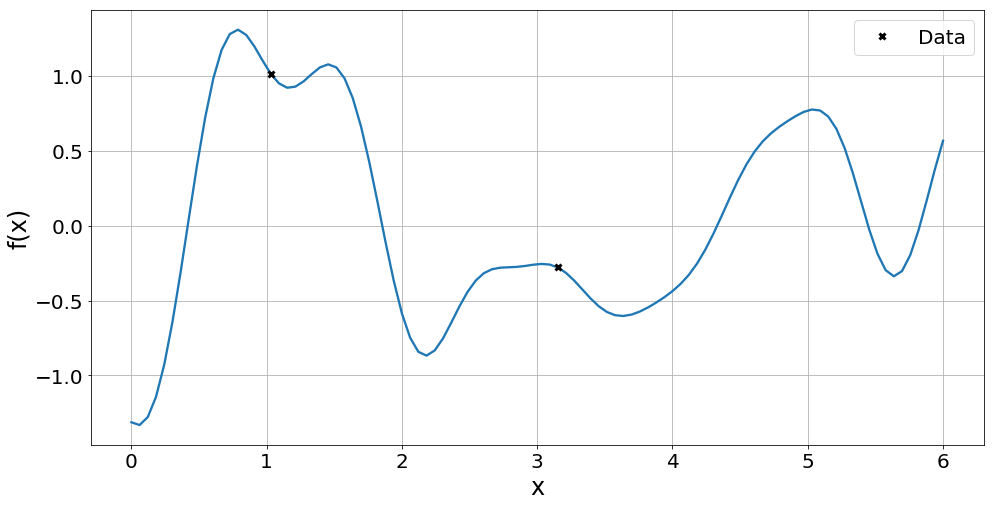

In [4]:
# Plot ground truth and training set
fig = utils.plot2D(None, None, X, [X, Y_true, ''], [X_sample, Y_sample, 'Data', 'kx'])

In [5]:
# Change noise parameter
sigma_n = 0.0
# Construct models with initial guess
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
m = gpflow.models.GPR(X_sample, Y_sample, kern=k)
m.likelihood.variance = sigma_n
m.compile()
# Print out model
m

In [6]:
gpflow.train.ScipyOptimizer().minimize(m)
m

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2.248343
  Number of iterations: 17
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2.248343
  Number of iterations: 17
  Number of functions evaluations: 21


In [7]:
# Predict with model
mean, var = m.predict_y(X)

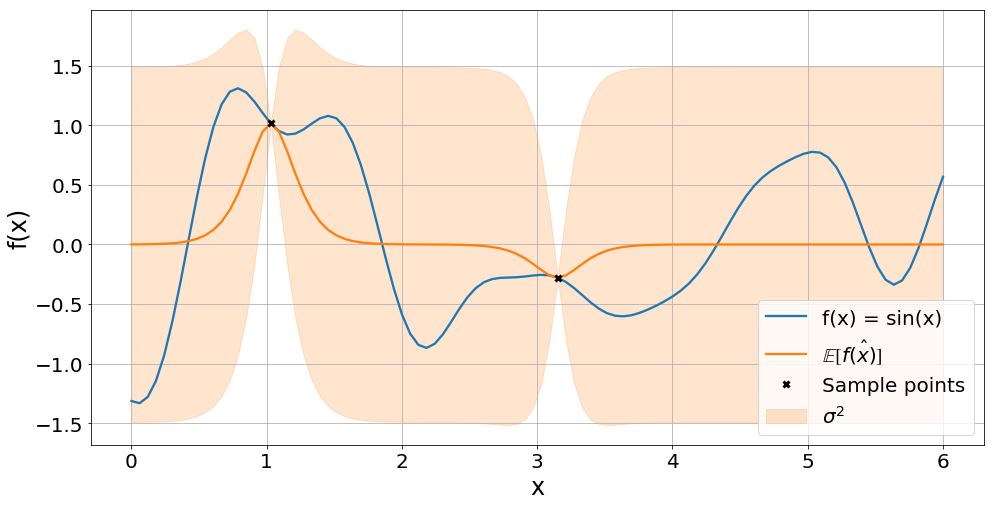

In [8]:
# Plot posterior
fig = utils.plot2D(mean, var, X, [X, Y_true, 'f(x) = sin(x)'], [X, mean, '$\mathbb{E[}\hat{f(x)}\mathbb{]}$'], [X_sample, Y_sample, 'Sample points', 'kx'])

Beta_t = 6.9868651520494724


Beta_t = 9.759453874289253


Beta_t = 11.381314306721912


Beta_t = 12.532042596529035


Beta_t = 13.424616801785874


Beta_t = 14.153903028961693


Beta_t = 14.770505748270725


Beta_t = 15.304631318768816
Beta_t = 15.77576346139435


Beta_t = 16.197205524025655


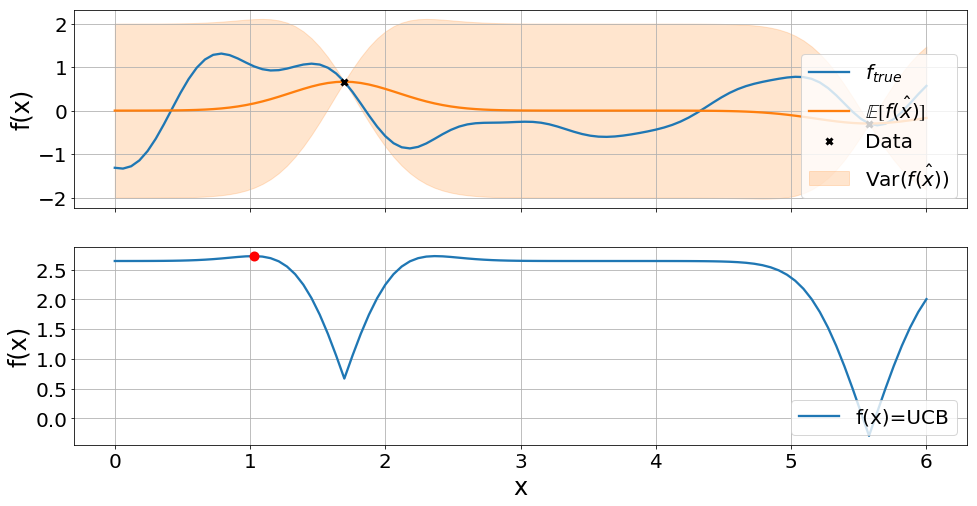

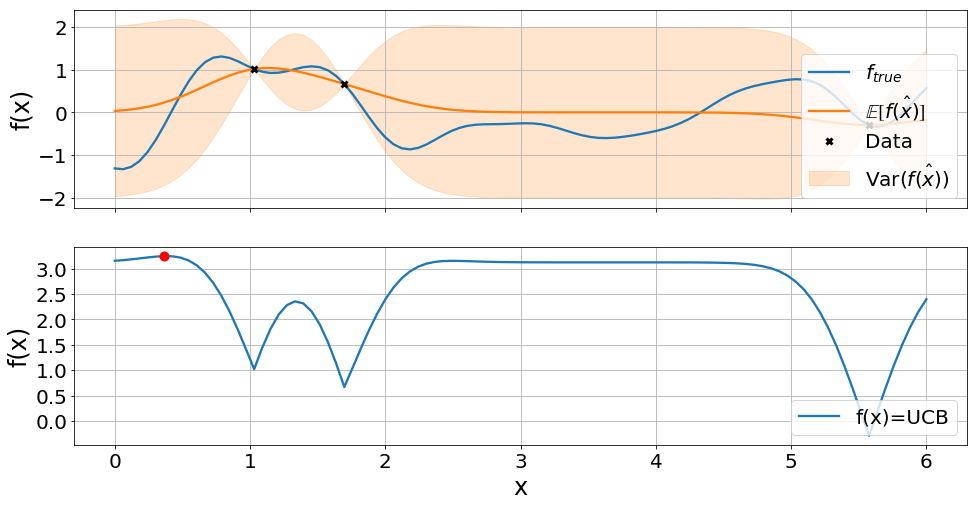

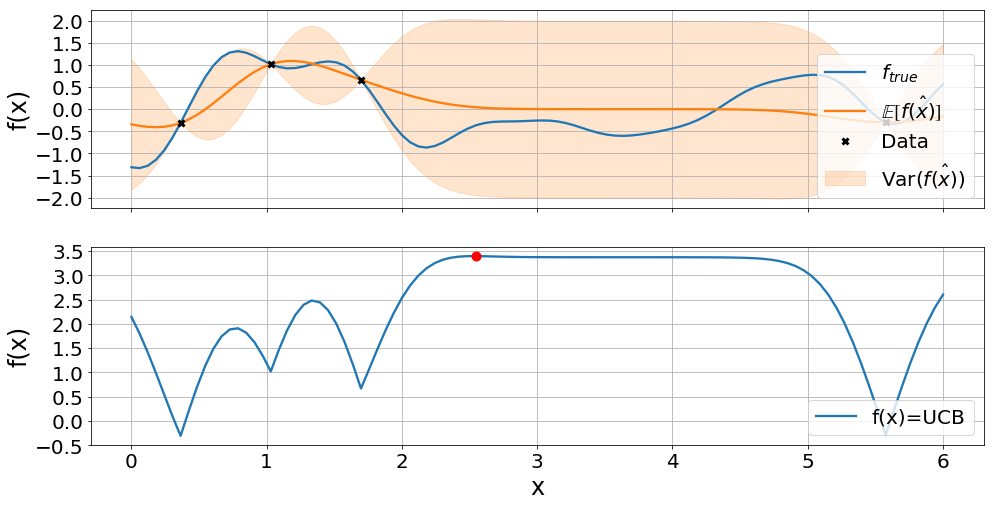

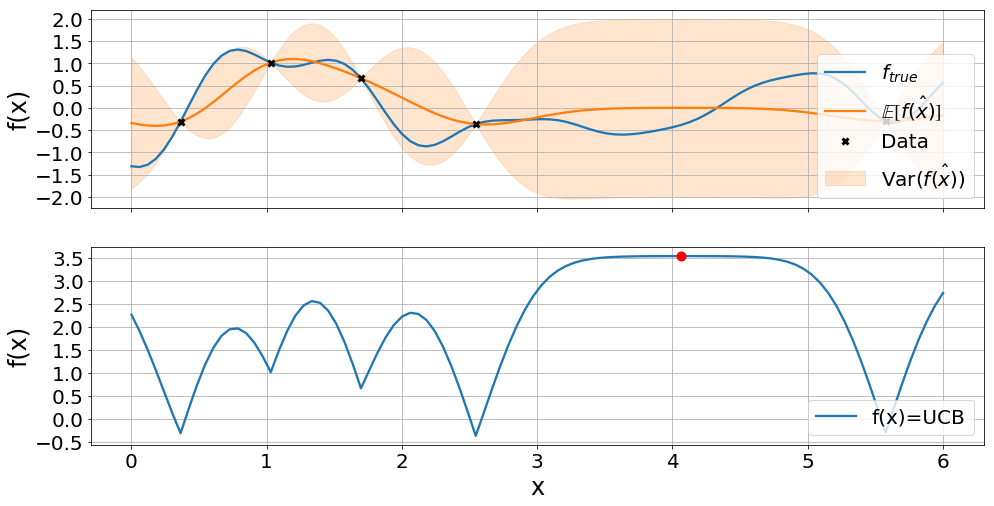

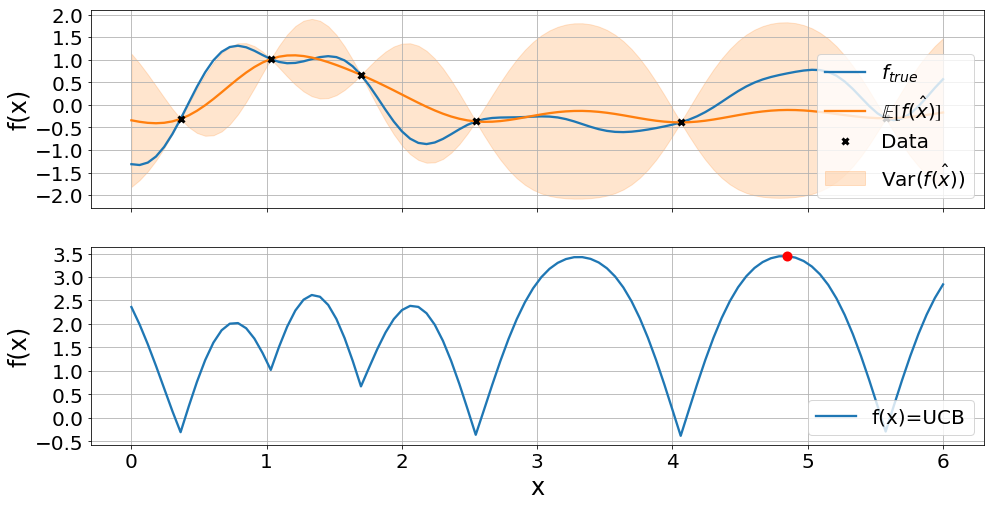

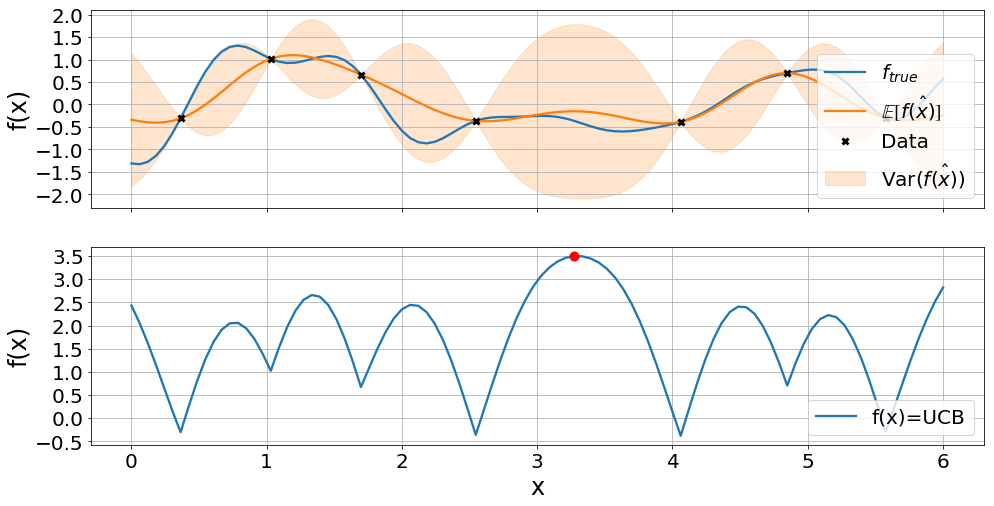

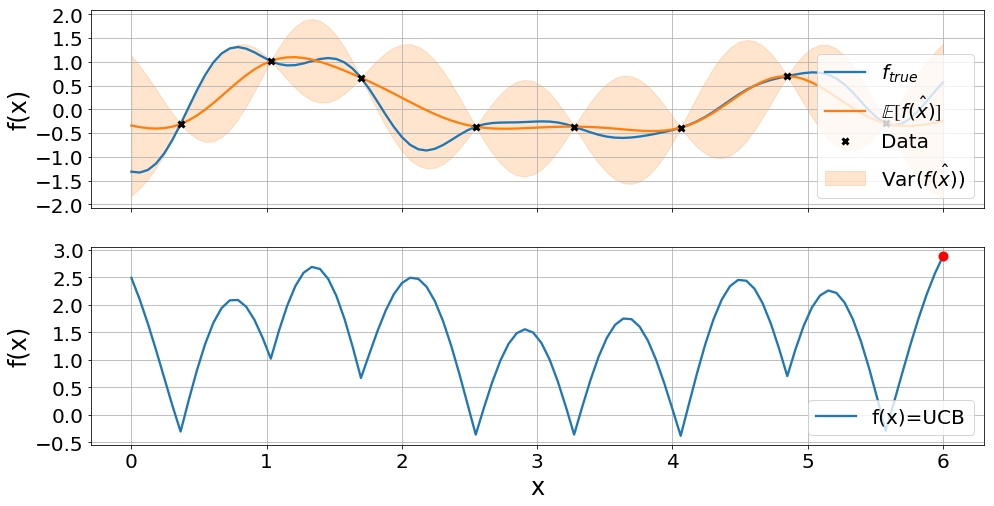

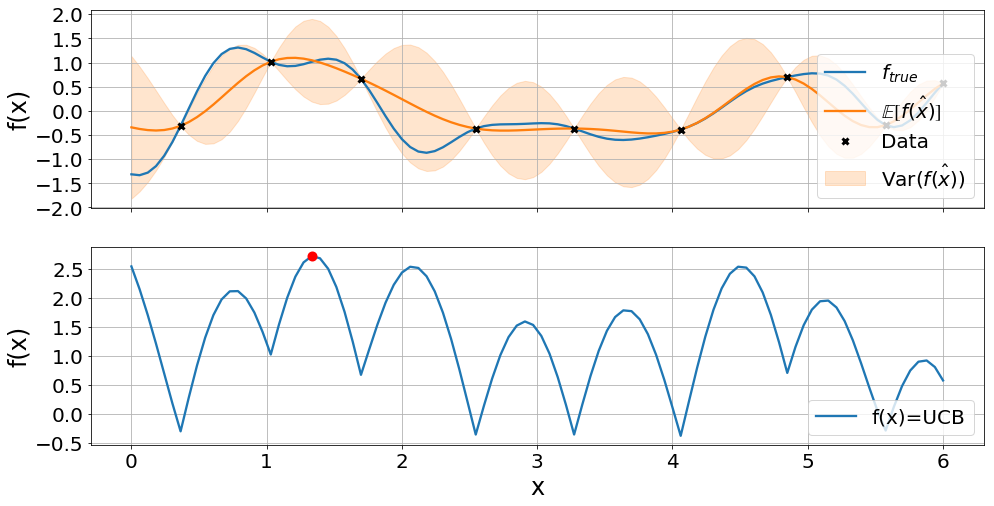

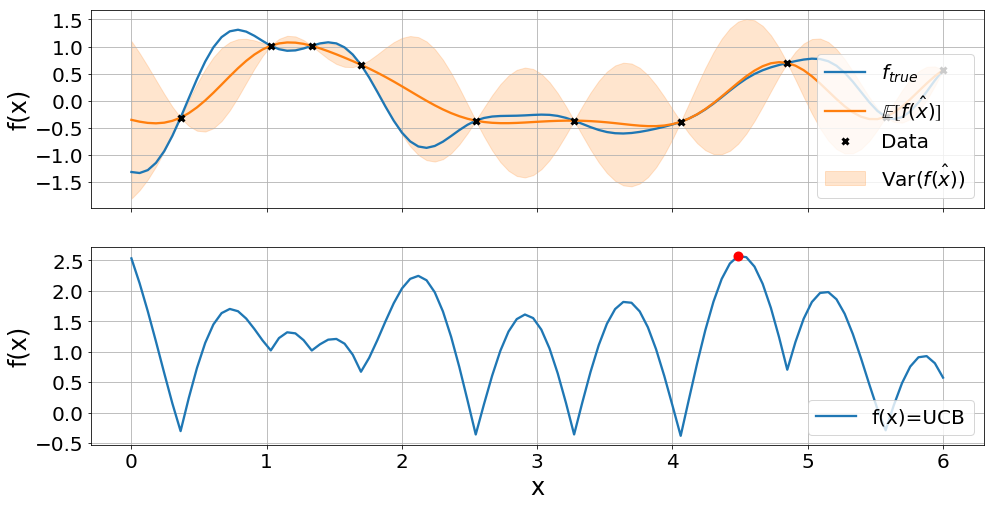

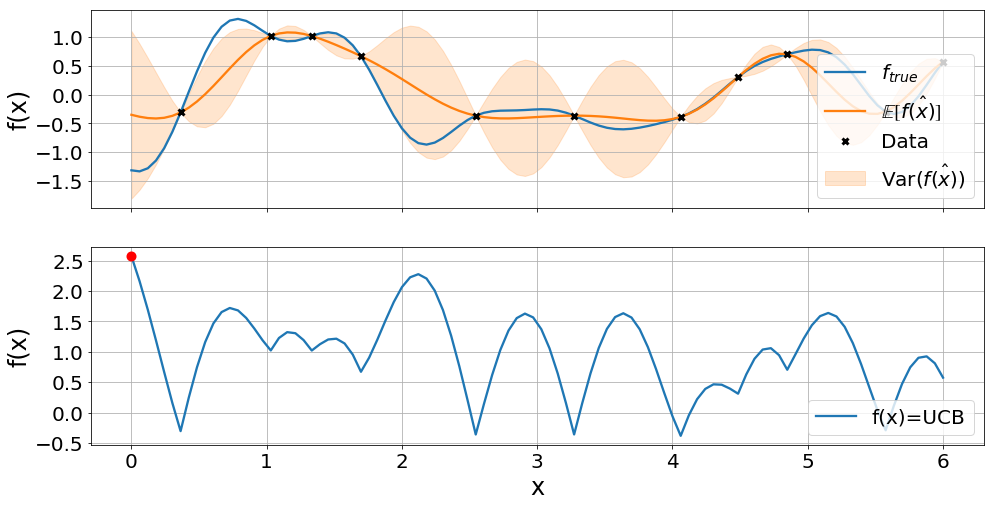

In [9]:
# Set some parameters
k = gpflow.kernels.RBF(1, lengthscales=lengthscale)
N_samples = 10
sigma_n = 0.0
delta = 0.2 # Delta = ]0,1[
D = X.size # |D| = cardinality of a set: array.size in numpy
# print("|D|: " + str(D))

# Assume some initial samples
size = 2
np.random.seed(55)
index = np.random.choice(range(len(X)), size=size, replace=False)
X_sample = X[index]
Y_sample = Y_true[index]

# Compute EI
for i in range(N_samples):
    print('Iteration=' + str(i+1) + "/" + str(N_samples))
    # Estimate model on samples
    m = gpflow.models.GPR(X_sample, Y_sample, kern=k)
    m.likelihood.variance = sigma_n
#     m.kern.lengthscales.trainable = False
#     m.likelihood.variance.trainable = False
    m.compile()
#     gpflow.train.ScipyOptimizer().minimize(m)
    
    # Predict with model
    mean, var = m.predict_y(X)
    
    # Calculate UCB
    beta_t = 2 * np.log( D * (i+1)**2 * np.pi **2 / 6 * delta )
    print("Beta_t = " + str(beta_t))
    ucb = acq.get_ucb(mean, var, beta_t)
    
    # Plot
    utils.plot_Acq(mean, var, X, Y_true, X_sample, Y_sample, True, [X, ucb, 'f(x)=UCB', False])
    
    # Append new point
    X_sample = np.append(X_sample, [X[np.argmax(ucb)]], axis=0)
    Y_sample = np.append(Y_sample, [Y_true[np.argmax(ucb)]], axis=0)

## 2D Experiment

[[8 5]
 [0 2]]
X_sample=[[ 2.33333333  0.33333333]
 [-3.         -1.66666667]]
Y_sample=[[-0.73460412]
 [ 0.06986689]]


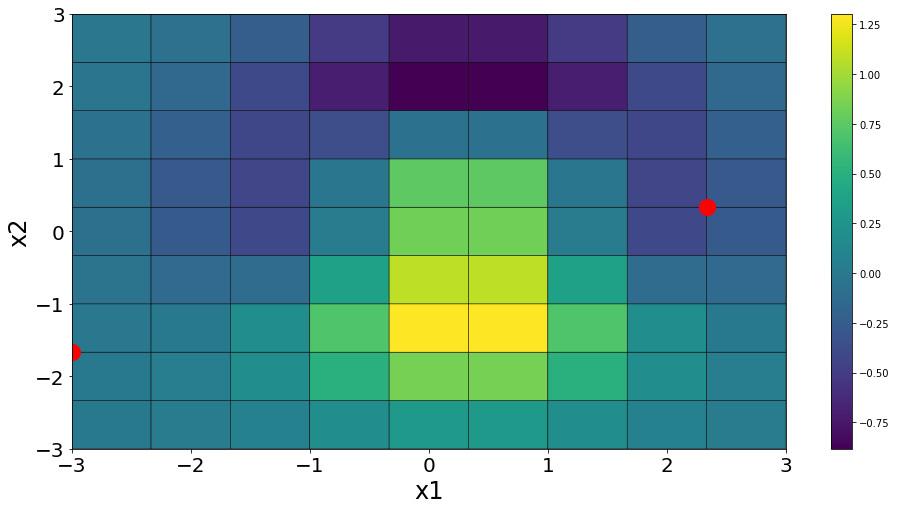

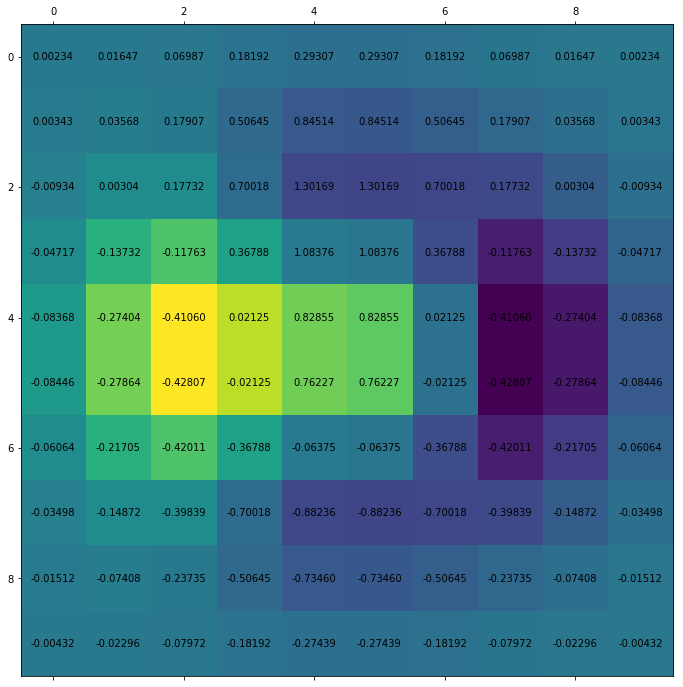

In [13]:
def f(x,y):
    return (1-(x**2+y**3)) * np.exp(-(x**2+y**2)/2)


markersize = 12
num = 10
delta = 0.2 # Delta = ]0,1[
# Generate data
bound = 3.
x1 = np.linspace(-bound, bound, num)
x2 = np.linspace(-bound, bound, num)
x1_mesh,x2_mesh = np.meshgrid(x1, x2)
X = np.dstack([x1_mesh, x2_mesh]).reshape(-1, 2)
z = f(x1_mesh, x2_mesh) # evaluation of the function on the grid
D = X.size # |D| = cardinality of a set: array.size in numpy
#print("|D|: " + str(D))

# Draw samples from feature vectors and function by a given index
size = 2
np.random.seed(7)
index = np.random.choice(range(len(x1)), size=(size,X.ndim), replace=False)
print(index)
samples = utils.sampleFeature([x1,x2], index)
X1_sample = samples[0]
X2_sample = samples[1]  
X_sample = np.column_stack((X1_sample, X2_sample))
Y_sample = utils.samplefromFunc(f=z, ind=index)

# Plot ground truth and samples
cbar = plt.pcolor(x1, x2, z, edgecolors='k', linewidths=0.5)
plt.colorbar(cbar)
for r in range(len(index)):
    plt.plot(x1[index[r][0]], x2[index[r][1]],marker='.', color='r', linestyle='none', markersize=markersize+20)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.xlabel('x1', fontsize=fontsize_label)
plt.ylabel('x2', fontsize=fontsize_label)
ax = plt.gca()
ax.set_xlim(-bound, bound)
ax.set_ylim(-bound, bound)

print("X_sample="+str(X_sample))
print("Y_sample="+str(Y_sample))


fig = plt.figure(figsize=(18, 12))
ax = plt.gca()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(z.T, cmap=cm.viridis)

for (i, j), val in np.ndenumerate(z):
    ax.text(j, i, '{:0.5f}'.format(val), ha='center', va='center')

plt.show()

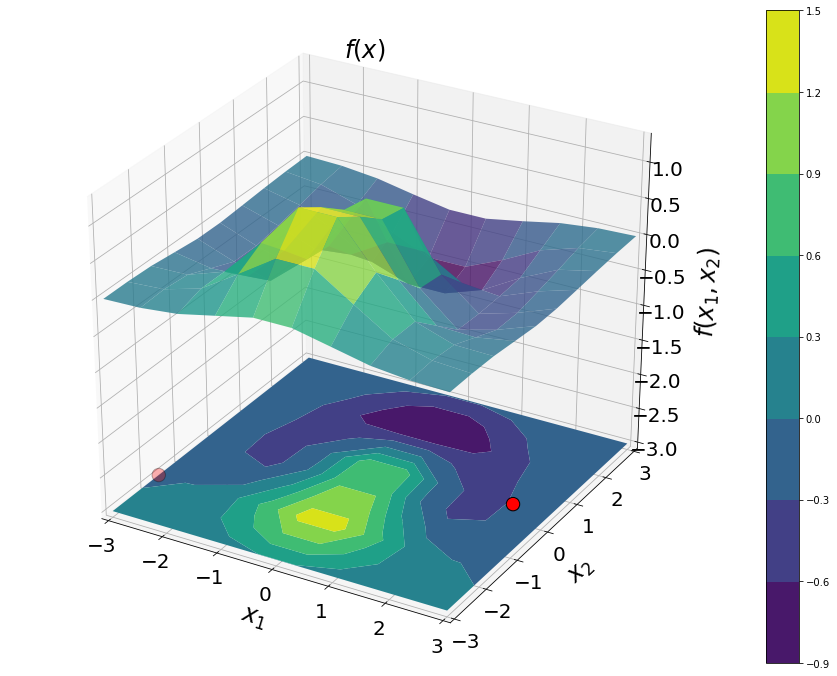

In [5]:
offset = -3.
utils.plot3D(x1_mesh, x2_mesh, z, X_sample[:,0], X_sample[:,1], offset, bound, markersize=180)

In [6]:
# Change noise parameter
sigma_n = 0.0
# Construct models with initial guess
k = gpflow.kernels.RBF(2,active_dims=[0,1], lengthscales=1.0,ARD=True)
m = gpflow.models.GPR(X_sample, Y_sample, kern=k)
m.likelihood.variance = sigma_n
m.compile()
# Print out model
m

In [7]:
gpflow.train.ScipyOptimizer().minimize(m)
m

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1.536888
  Number of iterations: 4
  Number of functions evaluations: 6


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1.536888
  Number of iterations: 4
  Number of functions evaluations: 6


In [8]:
mean, var = m.predict_y(X)
mean_square = mean.reshape(x1_mesh.shape) # Shape: (num,num)
var_square = var.reshape(x1_mesh.shape) # Shape: (num,num)

Beta_t = 17.583499885145546


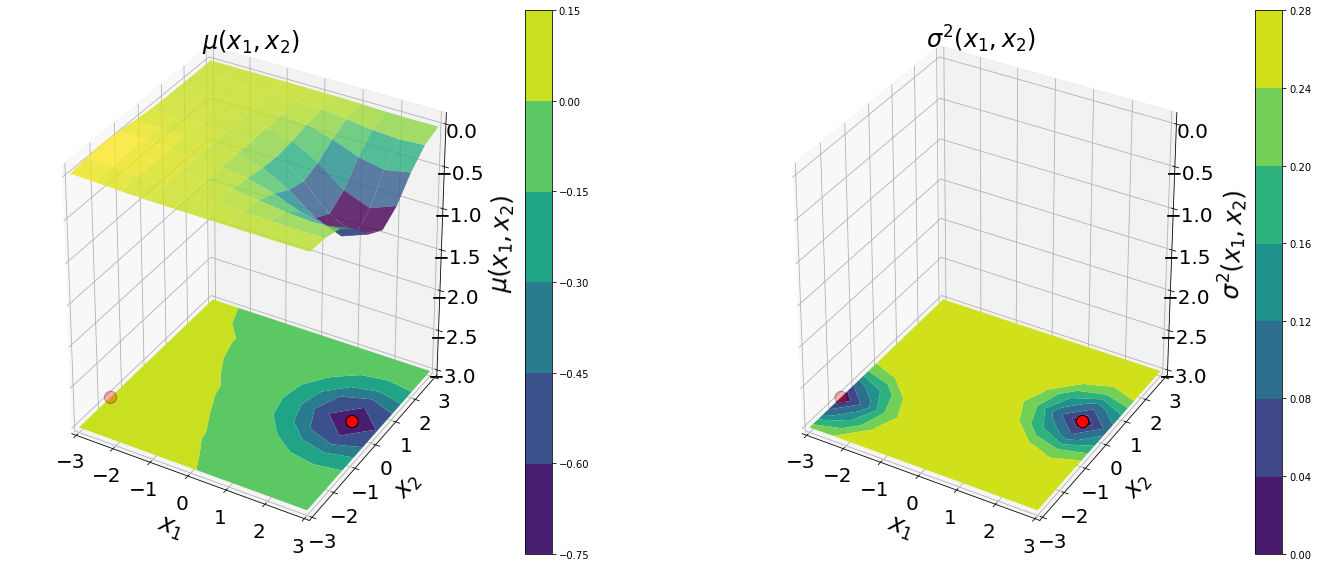

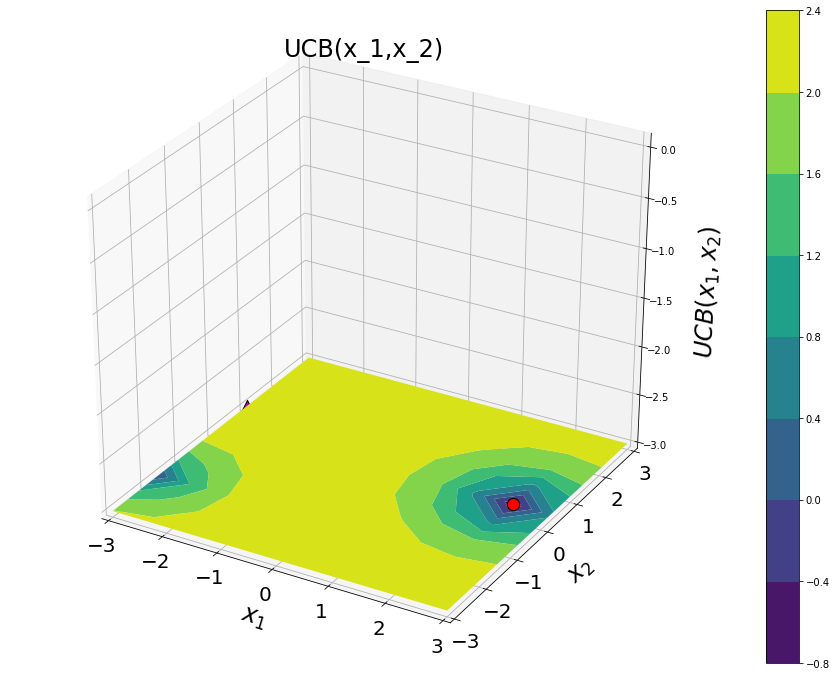

In [14]:
beta_t = 2 * np.log( D * (i+1)**2 * np.pi **2 / 6 * delta )
print("Beta_t = " + str(beta_t))
ucb = acq.get_ucb(mean, var, beta_t)
ucb_square = ucb.reshape(x1_mesh.shape)
utils.plotAcq3D(mean_square, var_square, x1_mesh, x2_mesh, X_sample, bound, True, [ucb_square, 'UCB(x_1,x_2)'])

Iterartion=1
Beta_t = 8.373159513169364
(100, 1)
Time needed for calculating EI=0.47936153411865234


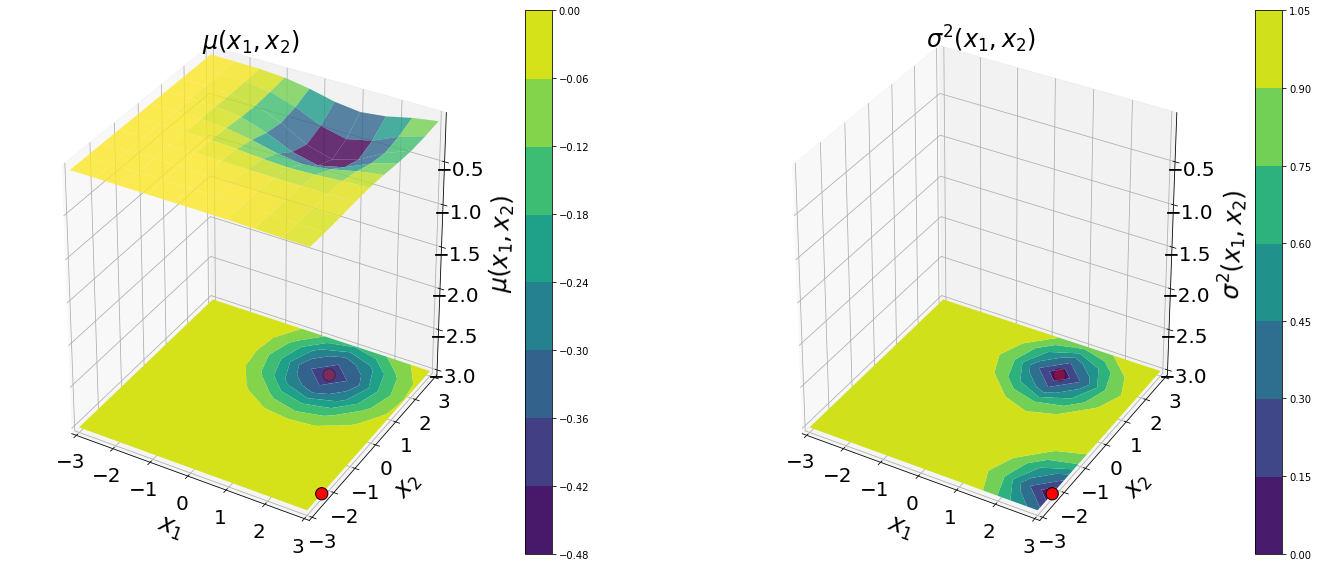

Time needed for plotting=1.157916784286499
Overall time needed=1.6375513076782227
Iterartion=2
Beta_t = 11.145748235409144
(100, 1)
Time needed for calculating EI=0.476581335067749


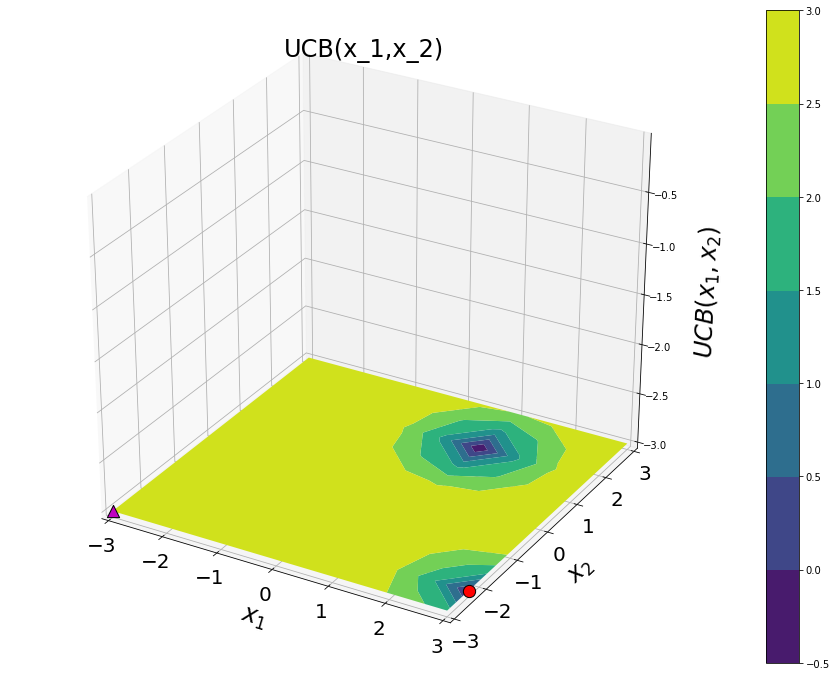

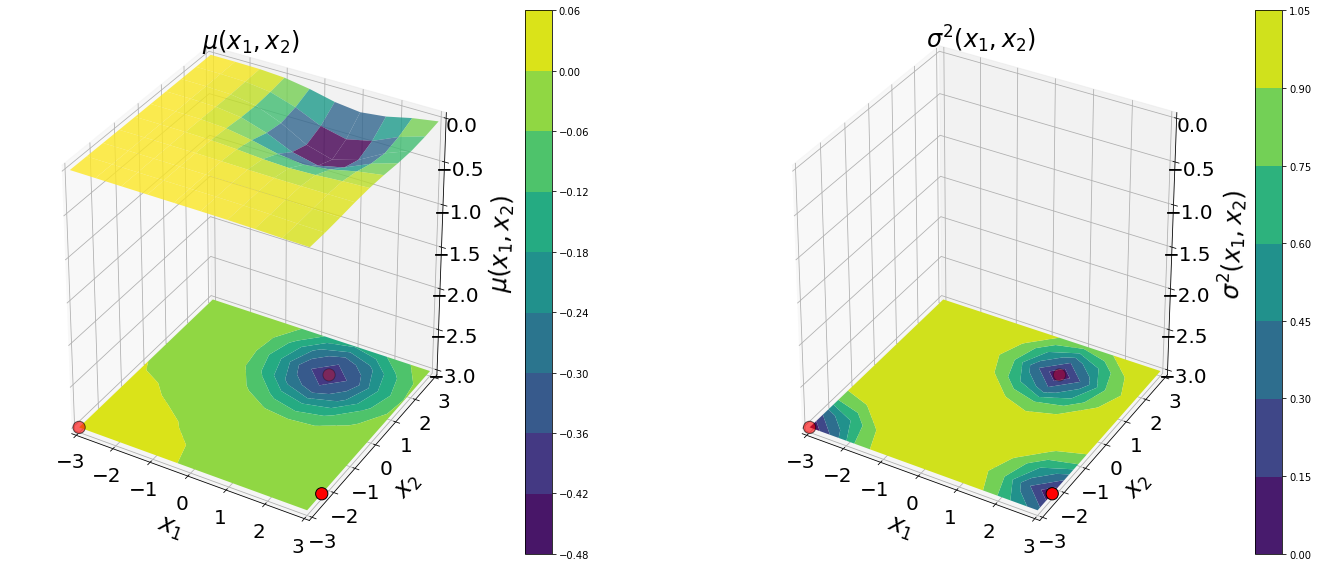

Time needed for plotting=1.660649299621582
Overall time needed=2.137498378753662
Iterartion=3
Beta_t = 12.767608667841802
(100, 1)
Time needed for calculating EI=0.6558332443237305


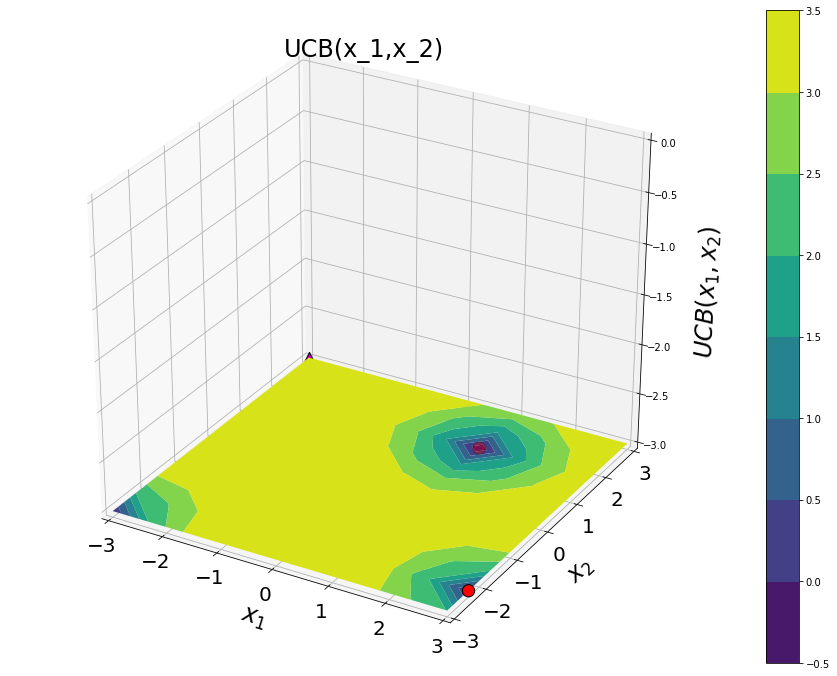

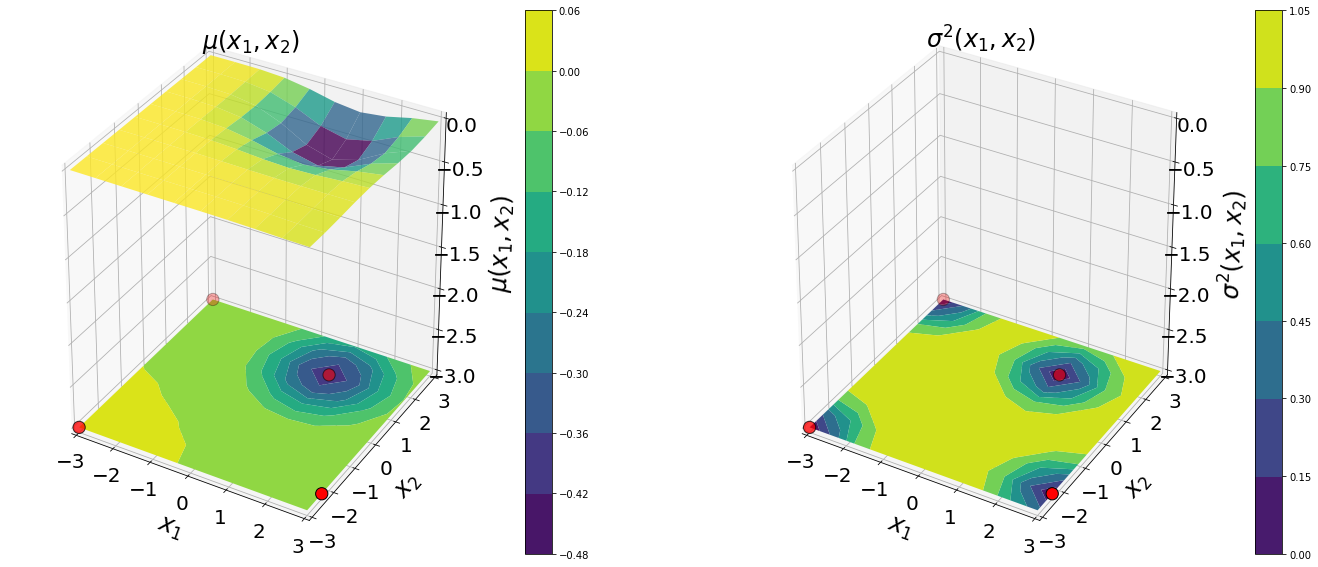

Time needed for plotting=1.727672815322876
Overall time needed=2.3837766647338867
Iterartion=4
Beta_t = 13.918336957648926
(100, 1)
Time needed for calculating EI=0.6099421977996826


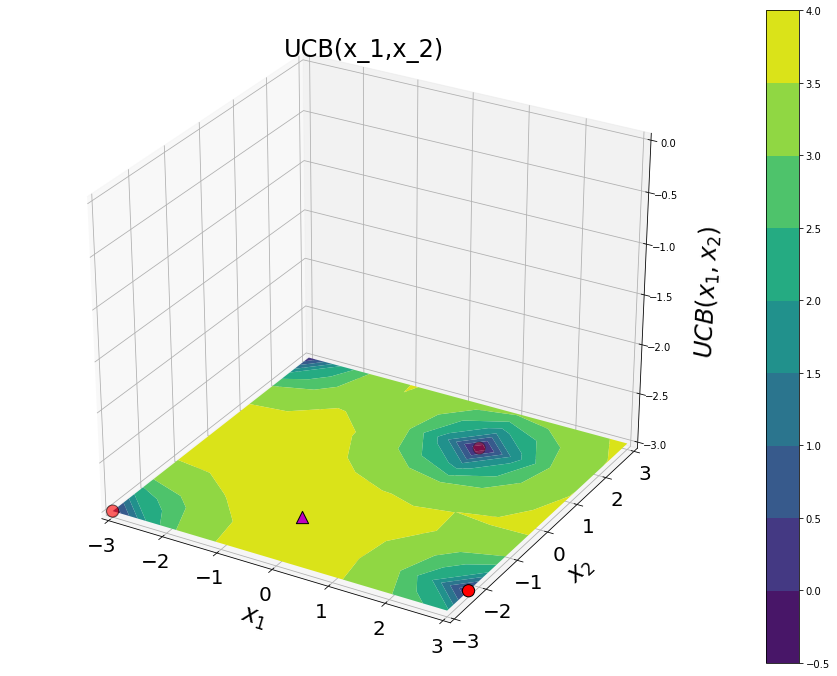

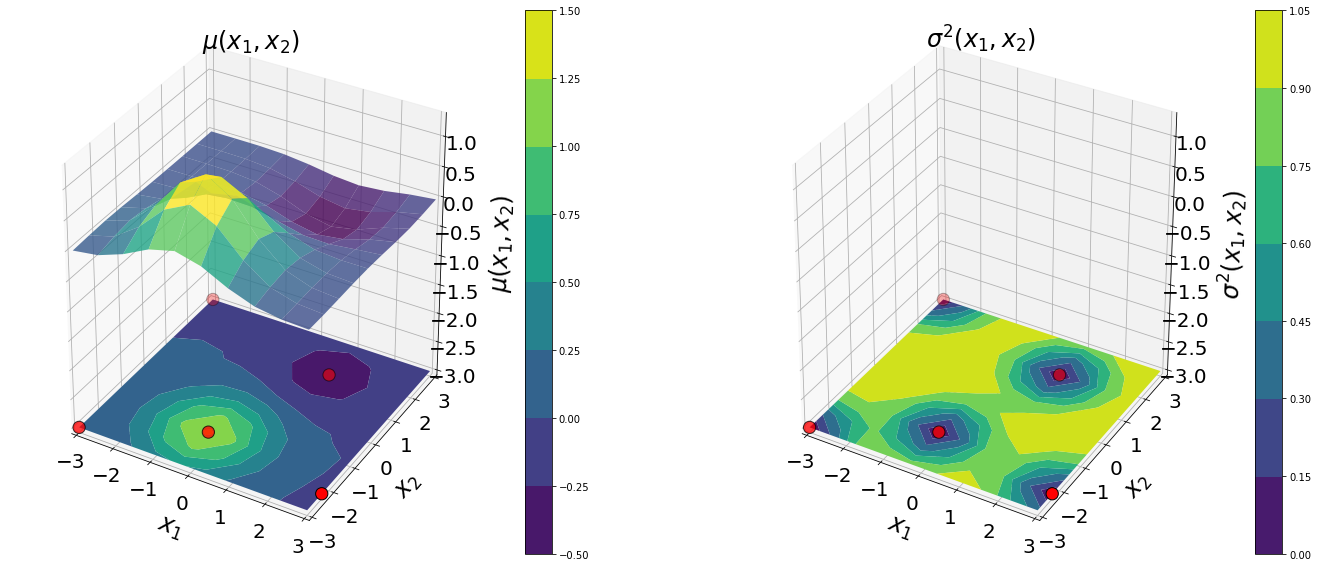

Time needed for plotting=1.823551893234253
Overall time needed=2.433929204940796
Iterartion=5
Beta_t = 14.810911162905764
(100, 1)
Time needed for calculating EI=0.6973369121551514


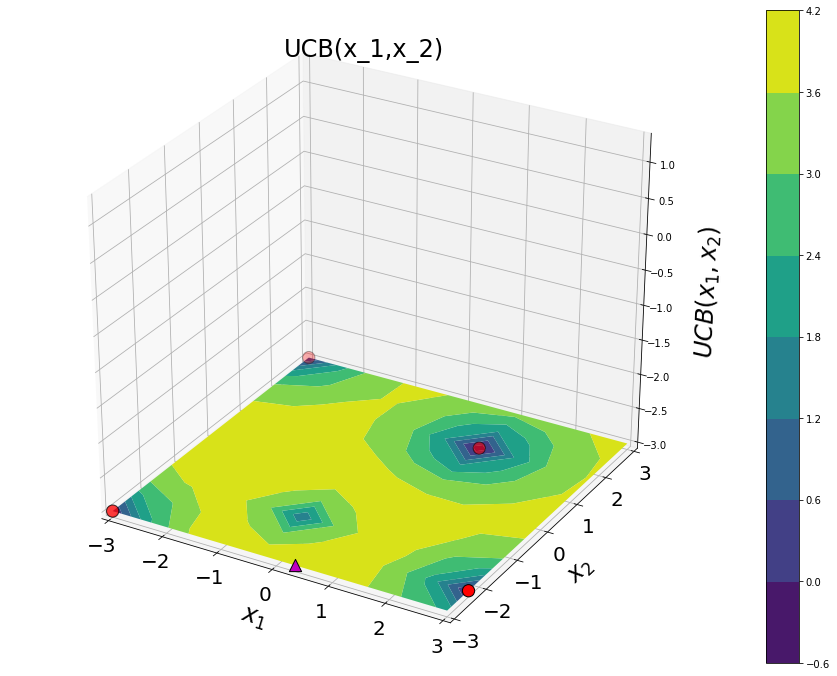

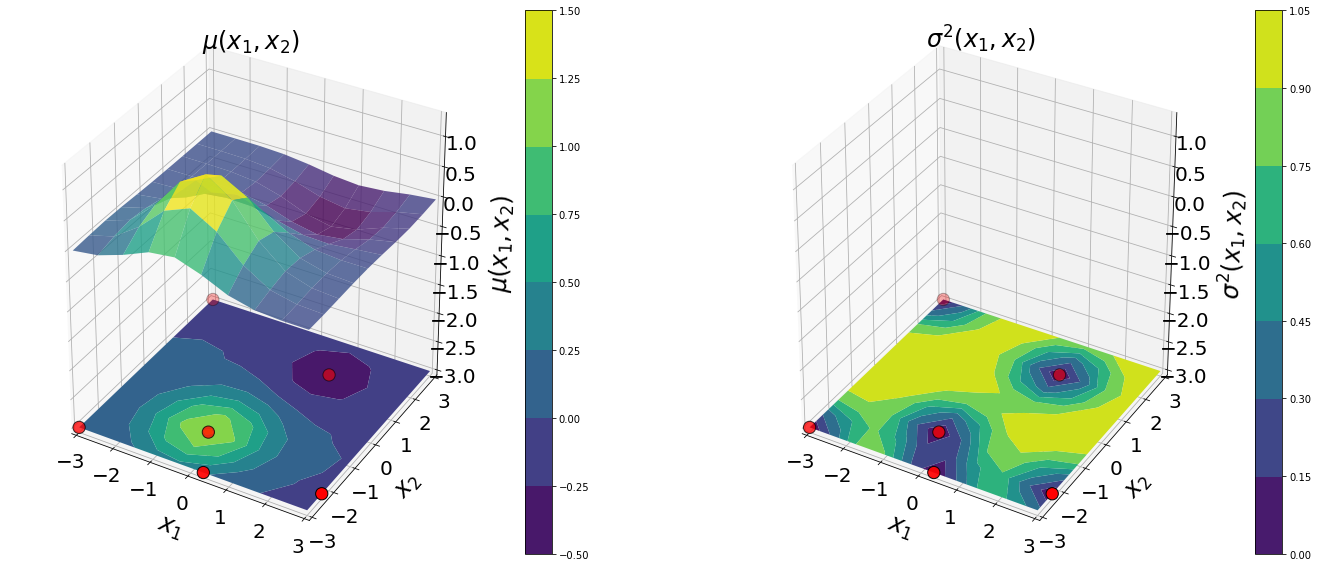

Time needed for plotting=1.839031457901001
Overall time needed=2.5366015434265137
Iterartion=6
Beta_t = 15.540197390081584
(100, 1)
Time needed for calculating EI=0.6180698871612549


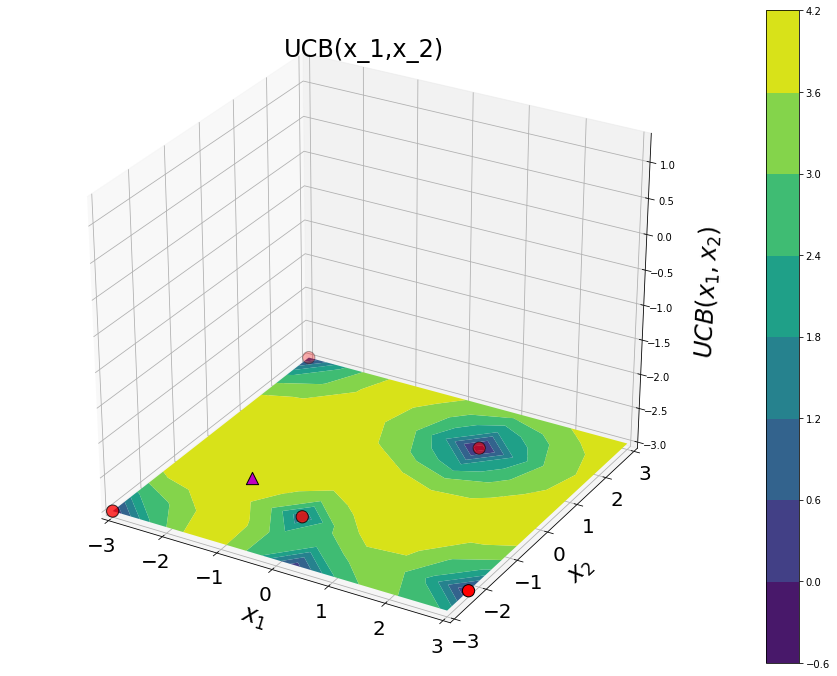

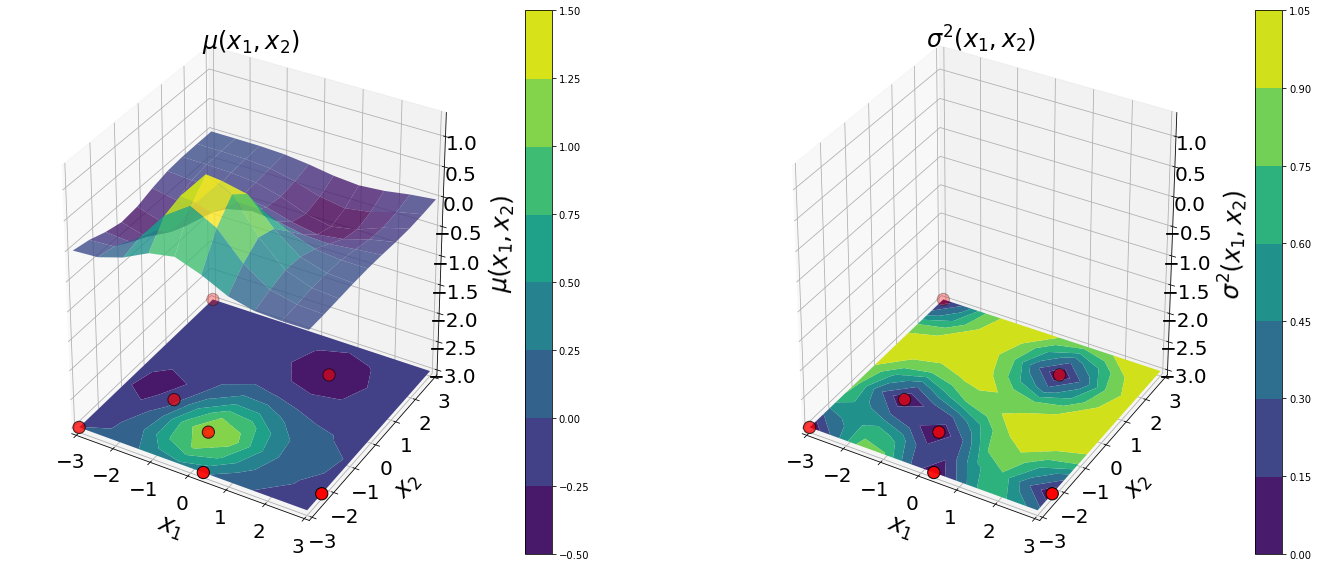

Time needed for plotting=1.5345029830932617
Overall time needed=2.1530773639678955
Iterartion=7
Beta_t = 16.156800109390616
(100, 1)
Time needed for calculating EI=0.6438295841217041


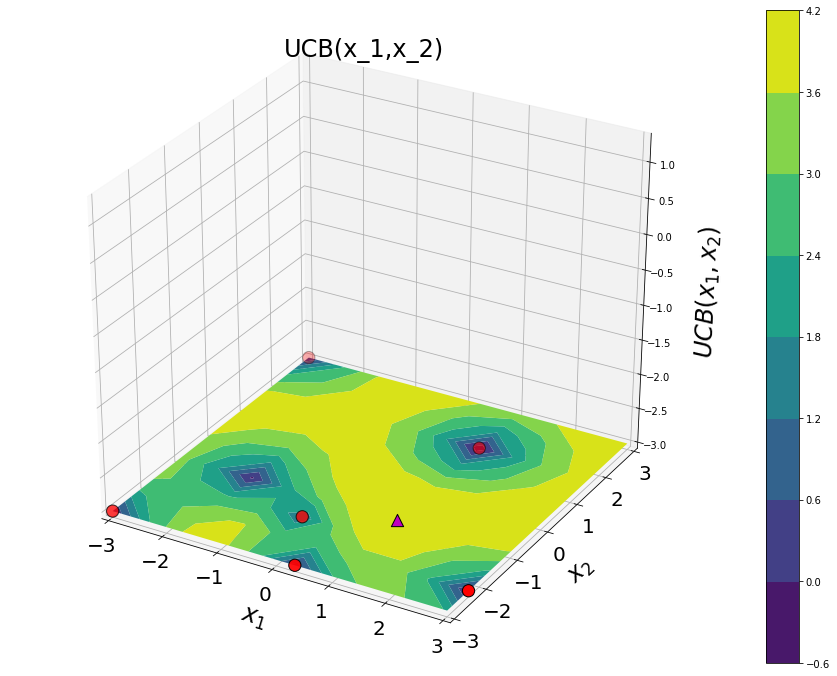

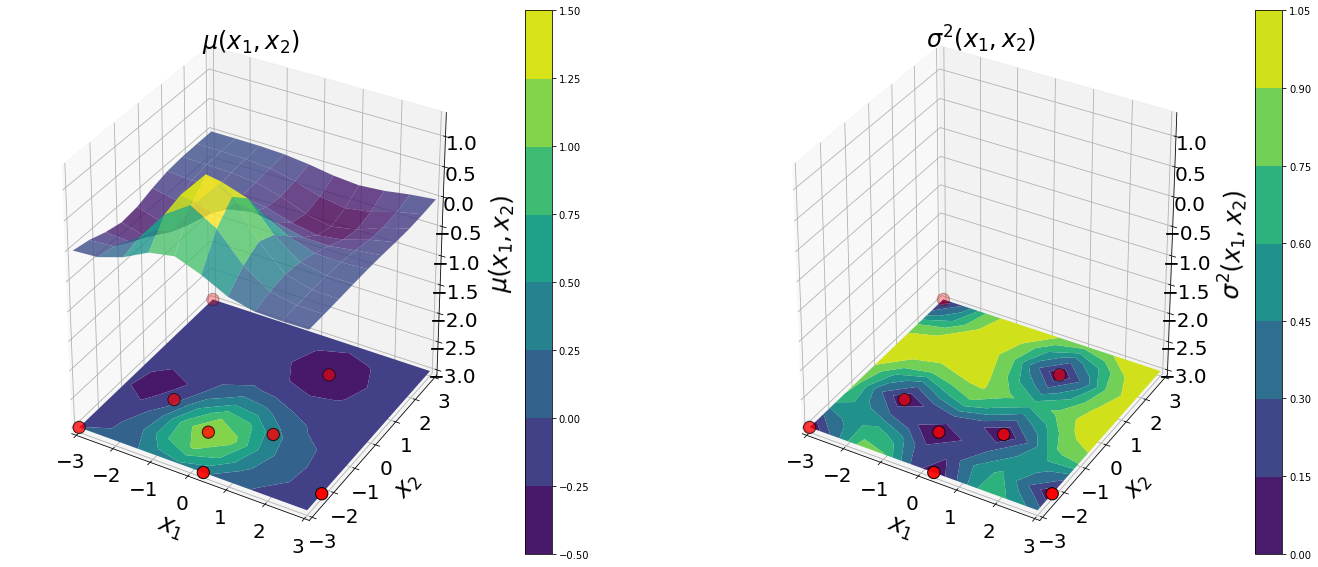

Time needed for plotting=1.6523878574371338
Overall time needed=2.2964653968811035
Iterartion=8
Beta_t = 16.690925679888707
(100, 1)
Time needed for calculating EI=0.6872167587280273


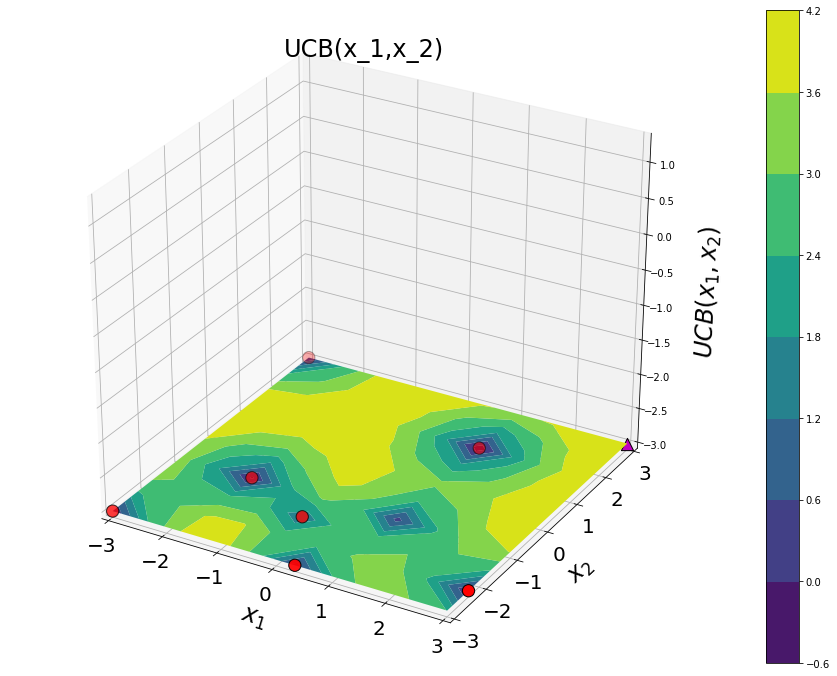

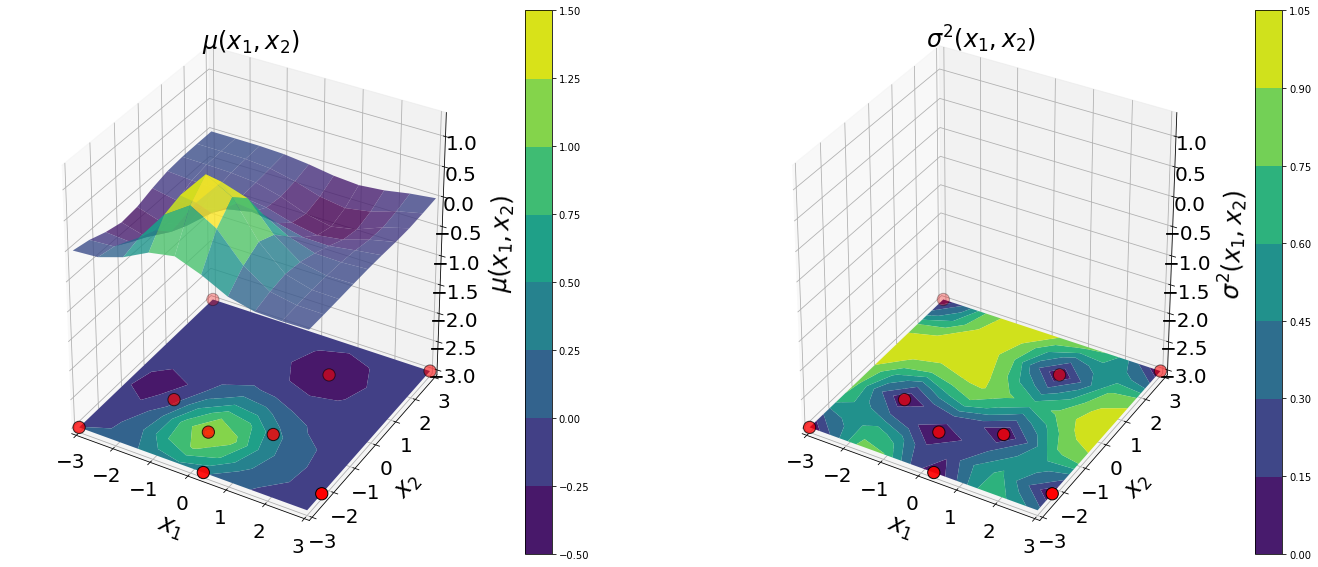

Time needed for plotting=1.5327651500701904
Overall time needed=2.2202417850494385
Iterartion=9
Beta_t = 17.162057822514242
(100, 1)
Time needed for calculating EI=0.7209515571594238


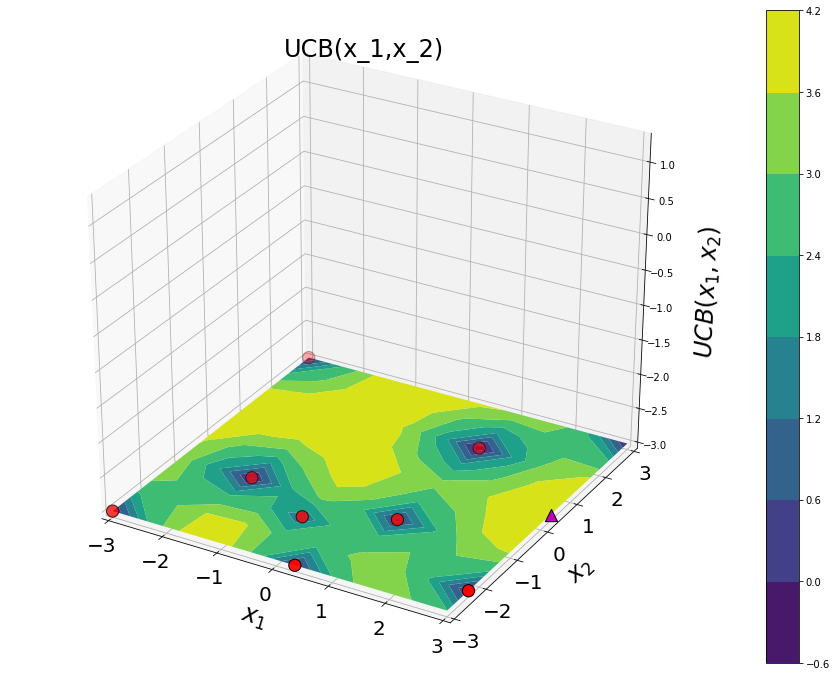

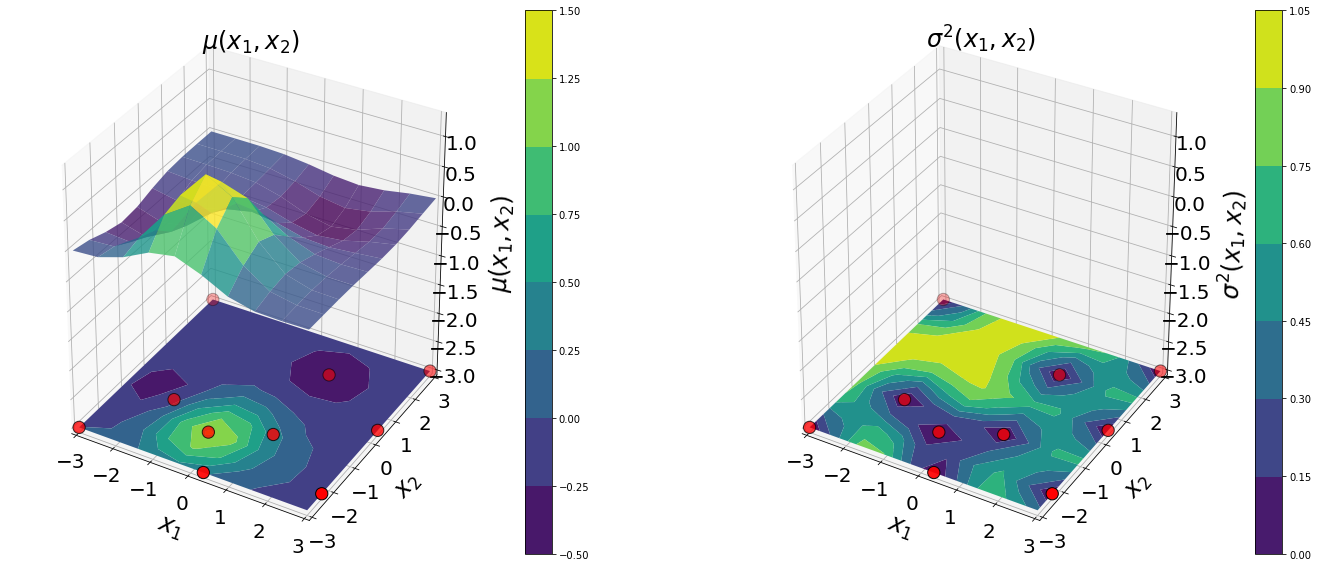

Time needed for plotting=1.5273239612579346
Overall time needed=2.248704195022583


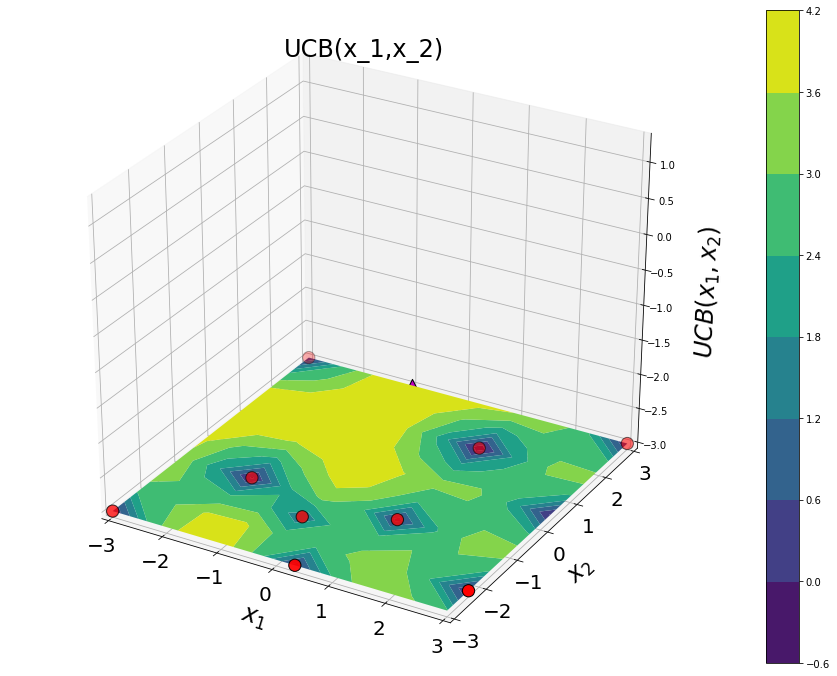

In [15]:
import time
# Set some parameters
lengthscale = 1.
k = gpflow.kernels.RBF(input_dim=2, lengthscales=lengthscale)
N_samples = 9
sigma_n = 0.0

# Draw samples from feature vectors and function by a given index
size = 2
np.random.seed(1991)
index = np.random.choice(range(len(x1)), size=(size,X.ndim), replace=False)
samples = utils.sampleFeature([x1,x2], index)
X1_sample = samples[0]
X2_sample = samples[1]  
X_sample = np.column_stack((X1_sample, X2_sample))
Y_sample = utils.samplefromFunc(f=z, ind=index)
# Compute EI
durations = []
for i in range(N_samples):
    print('Iteration=' + str(i+1) + "/" + str(N_samples))
    start_time = time.time()
    # Estimate model on samples
    m = gpflow.models.GPR(X_sample, Y_sample, kern=k)
    m.likelihood.variance = sigma_n
#     m.kern.lengthscales.trainable = False
#     m.likelihood.variance.trainable = False
    m.compile()
#     print(m)
#     gpflow.train.ScipyOptimizer().minimize(m)
    
    # Predict with model
    mean, var = m.predict_y(X)
    mean_square = mean.reshape(x1_mesh.shape) # Shape: (num,num)
    var_square = var.reshape(x1_mesh.shape) # Shape: (num,num)
    
    # Calculate UCB
    beta_t = 2 * np.log( D * (i+1)**2 * np.pi **2 / 6 * delta )
    print("Beta_t = " + str(beta_t))
    ucb = acq.get_ucb(mean, var, beta_t)
    ucb_square = ucb.reshape(x1_mesh.shape)
    elapsed_time = time.time() - start_time
    print("Time needed for calculating ucb="+str(elapsed_time))
    # Plot
    start_time2 = time.time()
    utils.plotAcq3D(mean_square, var_square, x1_mesh, x2_mesh, X_sample, bound, True, [ucb_square, '$UCB(x_1,x_2)$'])
    
    
    
#     fig = plt.figure(figsize=(16, 12))
#     ax = plt.gca()
#     cbar = plt.pcolor(x1, x2, ucb_square, edgecolors='k', linewidths=0.5)
# #     cbar = ax.contourf(x1_mesh, x2_mesh, ucb_square, zdir='z', offset=offset, cmap=cm.viridis, antialiased=True)
# #     ax.scatter(X1_sample, X2_sample, offset, marker='o',edgecolors='k', color='r', label="Data", s=150)
# #     ax.scatter3D(x1_mesh.reshape(-1)[np.argmax(ucb)], x2_mesh.reshape(-1)[np.argmax(ucb)], offset, marker='^',edgecolors='k', color='m', label="Data", s=150)
#     fig.colorbar(cbar)
    
#     for r in range(len(X_sample)):
#         plt.plot(X_sample[r][0], X_sample[r][1], marker='.', color='r', linestyle='none', markersize=markersize+20)   
#     ax.plot(x1_mesh.reshape(-1)[np.argmax(ucb)], x2_mesh.reshape(-1)[np.argmax(ucb)],marker='^', mew=markeredgewidth, 
#             markersize=markersize, color='m')
#     ax.set_title("$EI_(x_1,x_2)$", fontsize=fontsize_title)
#     plt.xticks(fontsize=fontsize_ticks)
#     plt.yticks(fontsize=fontsize_ticks)
#     plt.xlabel('x1', fontsize=fontsize_label)
#     plt.ylabel('x2', fontsize=fontsize_label)
#     ax.set_xlim(-bound-.5, bound+.5)
#     ax.set_ylim(-bound-.5, bound+.5)
    elapsed_time = time.time() - start_time2
    print("Time needed for plotting="+str(elapsed_time))
    # Append new point
    X_sample = np.vstack((X_sample, np.asarray([x1_mesh.reshape(-1)[np.argmax(ucb)], x2_mesh.reshape(-1)[np.argmax(ucb)]])))
    Y_sample = np.vstack((Y_sample,np.asarray([z.reshape(-1)[np.argmax(ucb)]])))
    elapsed_time = time.time() - start_time
    print("Overall time needed="+str(elapsed_time))
    print("----------------------------------------------------")
    durations.append(elapsed_time)

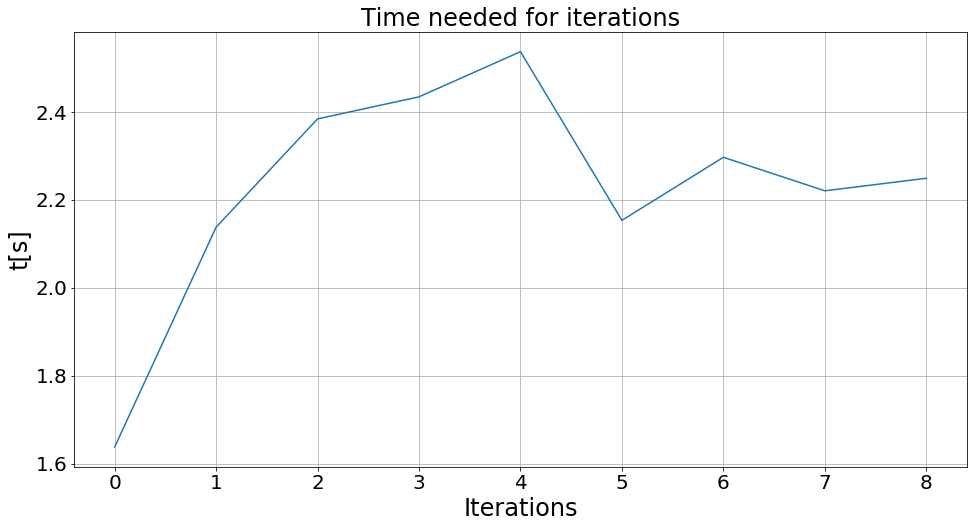

In [16]:
plt.plot(durations)
plt.title("Time needed for iterations", fontsize=fontsize_title)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)
plt.xlabel('Iterations', fontsize=fontsize_label)
plt.ylabel('t[s]', fontsize=fontsize_label)
plt.grid()